In [1]:
# Fix accuracy

In [2]:
import numpy as np
import pandas as pd
import pickle, os, csv, math, time, joblib
from joblib import Parallel, delayed
import datetime as dt
from datetime import date, datetime, timedelta
from collections import Counter
import copy as cp
import tqdm
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, accuracy_score
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import collections 
#import shap
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
np.seterr(all="ignore")
import matplotlib.pyplot as plt
import tqdm
import math

# Simulation
* Simulate RL data from two different distributions, generate transition tuples

In [3]:
# Generate transition matrices, separate distributions for each one
# We have to ensure that these transitions keep the next state calculations within some reasonable range
# Make sure that states aren't exploding
shape, scale = 2, 10
transition_foreground = np.random.gamma(shape, scale, (12, 10))

mu, sigma = 0, 4 # mean and standard deviation
transition_background = np.random.normal(mu, sigma, (12, 10))

In [4]:
# Generate reward function
mu, sigma = 0, 5
reward_function = np.random.normal(mu, sigma, (12, 1))

In [5]:
# Params
exploit = 0.6
explore = 1-exploit
num_samples = 100
num_patients = 100
actions = [[0, 0], [0, 1], [1, 0], [1, 1]]
mu, sigma = 0, 4

In [6]:
transition_tuples = []
for k, pat in enumerate(tqdm.tqdm(range(num_patients))):
    
    flip = np.random.choice(2)
    if flip == 0:
        ds = 'foreground'
    else:
        ds = 'background'
    # Generate a random initial state
    s = np.random.normal(mu, sigma, (10, 1))
    
    # Generate all of the tuples for this patient
    for i in range(num_samples):
        flip = random.uniform(0, 1)
        # Exploit
        if flip < exploit:            
            all_rewards = []
            for j, a in enumerate(actions):
                a = np.asarray(a)
                a = np.reshape(a, (2, 1))
                s_a = np.concatenate((s, a))
                reward = np.dot(reward_function.T, s_a)
                all_rewards.append(reward)

            noise = np.random.normal(0, 0.05, 1)
            all_rewards = np.asarray(all_rewards)
            a = actions[np.argmax(all_rewards)]
            reward = np.max(all_rewards) + noise
            
            if ds == 'foreground':
                t_m = transition_foreground
            else:
                t_m = transition_background
            ns = np.matmul(s_a.T, t_m) / np.linalg.norm(np.matmul(s_a.T, t_m), ord=2)
            ns = np.add(ns, np.random.normal(0, 0.5, (1, 10))) # Add noise
            
        
        # Explore
        else:
            a = np.asarray(actions[np.random.choice(3)])
            a = np.reshape(a, (2, 1))
            s_a = np.concatenate((s, a)) # concatenate the state and action

            if ds == 'foreground':
                t_m = transition_foreground
            else:
                t_m = transition_background
            ns = np.matmul(s_a.T, t_m) / np.linalg.norm(np.matmul(s_a.T, t_m), ord=2)
            ns = np.add(ns, np.random.normal(0, 0.5, (1, 10))) # Add noise
            
            reward = np.dot(reward_function.T, s_a) + np.random.normal(0, 0.5, 1)

        # Transition tuple includes state, action, next state, reward, ds
        transition_tuples.append((s, list(a), ns, reward.flatten(), ds, i))
        s = ns.T

100%|██████████| 100/100 [00:01<00:00, 75.10it/s]


In [7]:
split = int(0.8*len(transition_tuples))
train_tuples = transition_tuples[:split]
test_tuples = transition_tuples[split:]

<AxesSubplot:>

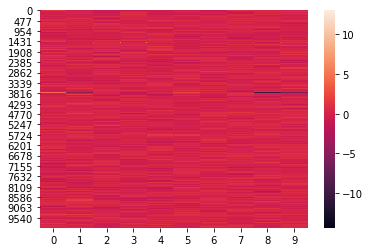

In [8]:
states = [a for (a, b, c, d, e, f) in transition_tuples]
states = np.squeeze(states)
sns.heatmap(states)

<AxesSubplot:>

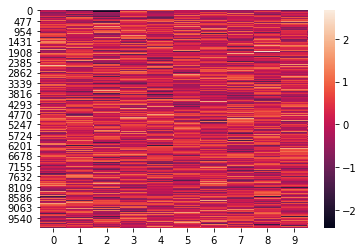

In [9]:
ns = [c for (a, b, c, d, e, f) in transition_tuples]
ns = np.squeeze(ns)
sns.heatmap(ns)

/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

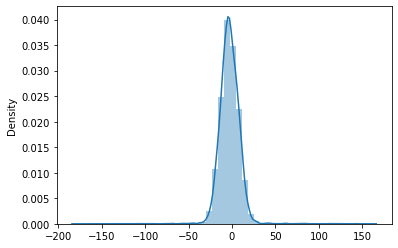

In [10]:
r = [d for (a, b, c, d, e, f) in transition_tuples]
sns.distplot(r)

In [11]:
def construct_dicts(train_tuples, test_tuples):
    train = {}
    test = {}
    elts = ['s', 'a', 'ns', 'r', 'ds', 'vnum']
    for elt in elts:
        train[elt] = []
        test[elt] = []

    for tup in train_tuples:
        train['s'].append(tup[0].flatten())
        a = tup[1]
        try:
            a = np.concatenate(a).ravel()
            a = list(a)
            train['a'].append(a)
        except:
            train['a'].append(a)
        train['ns'].append(tup[2].flatten())
        train['r'].append(tup[3])
        train['ds'].append(tup[4])
        train['vnum'].append(tup[5])

    for tup in test_tuples:
        test['s'].append(tup[0].flatten())
        try:
            a = tup[1]
            a = np.concatenate(a).ravel()
            a = list(a)
            test['a'].append(a)
        except:
            test['a'].append(tup[1])
        test['ns'].append(tup[2].flatten())
        test['r'].append(tup[3])
        test['ds'].append(tup[4])
        test['vnum'].append(tup[5])
    return train, test

# FQI

## FQI on both datasets

In [12]:
# Define action space, the potential classes of action items. 
def a2c(action):
    actions = [[0, 0], [0, 1], [1, 0], [1, 1]]
    classes = []
    for a in action:
        a = list(a)
        for c in range(len(actions)):
            if actions[c] == a:
                classes.append(c) 
    return classes

def p2c(pred):
    if pred <= 0.25:
        action = [0, 0]
    elif pred <= 0.5:
        action = [0, 1]
    elif pred <= 0.75:
        action = [1, 0]
    else:
        action = [1, 1]
        
# Mapping states to actions?        
def c2a(c):
    d = {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]}
    return np.array([d[k] for k in c])

def random_weights(size=5):
    
    #w = 2*np.random.uniform(size=size) - 1
    w = norm(np.random.uniform(size=size))
    #w / np.sum(np.abs(w))
    
    return w

def norm(vec):
    return vec/np.sum(np.abs(vec))

def learnBehaviour(training_set, test_set):  
    floc = "simulated_fqi/behavior.pkl"
    #if os.path.exists(floc):
    #    behaviour_pi = pickle.load(open(floc, 'rb'))
    #else:
    # Use a linear regression to predict behavior
    behaviour_pi = LinearRegression()
    X = np.vstack((training_set['s'], test_set['s']))
    X = np.reshape(X, (-1, 10))
    y = a2c(np.vstack((training_set['a'], test_set['a'])))    
    behaviour_pi.fit(X,y)
    pickle.dump(behaviour_pi, open(floc, 'wb'))    
    
    return behaviour_pi

In [13]:
class FQIagent():
    def __init__(self, train_tuples, test_tuples, iters=150, gamma=0.99, batch_size=100, prioritize=False, estimator='lin',
                 weights=np.array([1, 1, 1, 1, 1])/5., maxT=36):
        
        self.iters = iters
        self.gamma = gamma
        self.batch_size = batch_size
        self.prioritize_a = prioritize
        self.training_set, self.test_set = construct_dicts(train_tuples, test_tuples)
        self.raw_test = test_tuples
        
        self.visits = {'train': len(train_tuples), 'test': len(test_tuples)}
        self.NV = {'train': len(train_tuples), 'test': len(test_tuples)}
        self.n_samples = len(self.training_set['s'])
        _, self.unique_actions, self.action_counts, _ = self.sub_actions()
        self.state_feats = [str(x) for x in range(10)]
        self.n_features = len(self.state_feats)
        self.reward_weights = weights
        self.maxT = maxT
        self.piB = learnBehaviour(self.training_set, self.test_set)
        self.n_actions = 4
        
        if estimator == 'tree':
            self.q_est = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=10, min_samples_split=2,
                                             random_state=0)
        elif estimator == 'gbm':
            self.q_est = LGBMRegressor(n_estimators=50, silent=True)

        elif estimator == 'nn':
            self.q_est = None
        
        elif estimator == 'lin':
            self.q_est = LinearRegression()
            
        self.piE = LinearRegression()#LGBMClassifier(n_estimators=50, silent=True)
        
        self.eval_est = LGBMRegressor(n_estimators=50, silent=True)

    def sub_actions(self):
        
        a = self.training_set['a']
        a = list(a)
        
        unique_actions = 0
        action_counts = 0
        n_actions = 0
        
        unique_actions, action_counts = np.unique(a, axis=0, return_counts=True)
        n_actions = len(unique_actions)
                
        return a, unique_actions, action_counts, n_actions
    
    def sampleTuples(self):
        
        # Get a batch of unprioritized samples:
        
        ids = list(np.random.choice(np.arange(self.n_samples), self.batch_size, replace=False))
        batch = {}
        for k in self.training_set.keys():
            batch[k] = np.asarray(self.training_set[k], dtype=object)[ids]
        batch['r'] = np.dot(batch['r'] * [1, 1, 10, 10, 100], self.reward_weights)
        batch['s_ids'] = np.asarray(ids, dtype=int)
        batch['ns_ids'] = np.asarray(ids, dtype=int) + 1
            
    
        return batch
    
    def fitQ(self, batch, Q):
        
        # input = [state action]
        x =  np.hstack((batch['s'], batch['a']))
        
        # target = r + gamma * max_a(Q(s', a))      == r for first iteration
        y = batch['r'] + (self.gamma * np.max(Q[batch['ns_ids'], :], axis=1))
        
        self.q_est.fit(x, y)   
    
    def updateQtable(self, Qtable, batch):
        
        for i, a in enumerate(self.unique_actions):
            #print(a, i)
            Qtable[batch['s_ids'], i] = self.q_est.predict(np.hstack((batch['ns'], np.tile(a, (self.batch_size,1)))))
        return Qtable
    
    def runFQI(self, repeats=10):
        
        print('Learning policy')
        meanQtable = np.zeros((self.n_samples + 1, self.n_actions))
        
        for r in range(repeats):
            print('Run', r, ':')
            print('Initialize: get batch, set initial Q')
            Qtable = np.zeros((self.n_samples + 1, self.n_actions))
            Qdist = []

            #print('Run FQI')
            for iteration in range(self.iters):

                # copy q-table
                Qold = cp.deepcopy(Qtable)

                # sample batch  
                batch = self.sampleTuples()

                # learn q_est with samples, targets from batch
                self.fitQ(batch, Qtable)

                # update Q table for all s given new estimator
                self.updateQtable(Qtable, batch)

                # check divergence from last estimate
                Qdist.append(mean_absolute_error(Qold, Qtable))
         
            #plt.plot(Qdist)
            meanQtable += Qtable
        
        meanQtable = meanQtable / repeats
        print('Learn policy')
        self.getPi(meanQtable)
        return Qdist
                    
    
    def getPi(self, Qtable):
        optA = np.argmax(Qtable, axis=1)
        print("Opta: ", optA)
        #print("Fitting to training set")
        #print("Optimal actions: ", optA)
        self.piE.fit(self.training_set['s'], optA[:-1])
        #print("Done Fitting")
    
    def testPi(self, behavior):
        accurate = 0
        total = 0
        
        for tup in self.raw_test:
            s = tup[0]
            try:
                a = tup[1]
                a = np.concatenate(a).ravel()
                a = list(a)
            except:
                a = tup[1]
            # actions based on policy we learn
            s = s.reshape((1, 10))
            evalA = self.piE.predict(s)
            
            # predicted actions based on historical actions model
            behavB = behavior.predict(s)
            
            if behavB <= 0.25:
                behavB = 0
            elif behavB <= 0.5:
                behavB = 1
            elif behavB <= 0.75:
                behavB = 2
            else:
                behavB = 3
            
            # actual historical actions
            actions = [[0, 0], [0, 1], [1, 0], [1, 1]]
            behavA = actions.index(a)
            
            if behavA == behavB:
                accurate += 1
            total += 1
        
        return float(accurate)/total

Learning policy
Run 0 :
Initialize: get batch, set initial Q
Learn policy
Opta:  [0 3 2 ... 1 0 0]


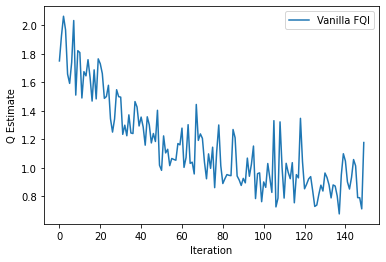

In [18]:
fqi_agent = FQIagent(train_tuples=train_tuples, test_tuples=test_tuples)
Q_dist = fqi_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "Vanilla FQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

## FQI on separate datasets

### Foreground dataset

### Background

# CFQI

In [19]:
class CFQIagent():
    def __init__(self, train_tuples, test_tuples, iters=150, gamma=0.99, batch_size=100, prioritize=False, estimator='lin',
                 weights=np.array([1, 1, 1, 1, 1])/5., maxT=36):
        
        self.iters = iters
        self.gamma = gamma
        self.batch_size = batch_size
        self.prioritize_a = prioritize
        self.training_set, self.test_set = construct_dicts(train_tuples, test_tuples)
        self.raw_test = test_tuples
        
        self.visits = {'train': len(train_tuples), 'test': len(test_tuples)}
        self.NV = {'train': len(train_tuples), 'test': len(test_tuples)}
        self.n_samples = len(self.training_set['s'])
        _, self.unique_actions, self.action_counts, _ = self.sub_actions()
        self.state_feats = [str(x) for x in range(10)]
        self.n_features = len(self.state_feats)
        self.reward_weights = weights
        self.maxT = maxT
        self.piB = learnBehaviour(self.training_set, self.test_set)
        self.n_actions = 4
        
        if estimator == 'tree':
            self.q_est = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=10, min_samples_split=2,
                                             random_state=0)
        elif estimator == 'gbm':
            self.q_est = LGBMRegressor(n_estimators=50, silent=True)

        elif estimator == 'nn':
            self.q_est = None
        
        elif estimator == 'lin':
            self.q_est_shared = LinearRegression()
            self.q_est_fg = LinearRegression()
            
        self.piE = LinearRegression()#LGBMClassifier(n_estimators=50, silent=True)
        
        self.eval_est = LGBMRegressor(n_estimators=50, silent=True)

    def sub_actions(self):
        
        a = self.training_set['a']
        a = list(a)
        
        unique_actions = 0
        action_counts = 0
        n_actions = 0
        
        unique_actions, action_counts = np.unique(a, axis=0, return_counts=True)
        n_actions = len(unique_actions)
                
        return a, unique_actions, action_counts, n_actions
    
    def sampleTuples(self):
        ids = list(np.random.choice(np.arange(self.n_samples), self.batch_size, replace=False))
        batch = {}
        for k in self.training_set.keys():
            batch[k] = np.asarray(self.training_set[k], dtype=object)[ids]
        batch['r'] = np.dot(batch['r'] * [1, 1, 10, 10, 100], self.reward_weights)
        batch['s_ids'] = np.asarray(ids, dtype=int)
        batch['ns_ids'] = np.asarray(ids, dtype=int) + 1
            
    
        return batch
    
    def fitQ(self, batch, Q):
        
        # Divide into foreground and background batches. 
        batch_foreground = {}
        batch_background = {}
        
        elts = ['s', 'a', 'ns', 'r', 'ds', 'vnum', 's_ids', 'ns_ids']
        for el in elts:
            batch_foreground[el] = []
            batch_background[el] = []
        
        for i in range(len(batch['s_ids'])):
            if batch['ds'][i] == 'foreground':
                for k in batch.keys():
                    batch_foreground[k].append(batch[k][i])
            else:
                for k in batch.keys():
                    batch_background[k].append(batch[k][i])
            
        # input = [state action]
        x_fg =  np.hstack((batch_foreground['s'], batch_foreground['a']))
        x_shared = np.hstack((batch['s'], batch['a'])) 
        
        # target = r + gamma * max_a(Q(s', a))      == r for first iteration
        y_fg = batch_foreground['r'] + (self.gamma * np.max(Q[batch_foreground['ns_ids'], :], axis=1))
        y_shared = batch['r'] + (self.gamma * np.max(Q[batch['ns_ids'], :], axis=1))
        
        self.q_est_shared.fit(x_shared, y_shared)
        self.q_est_fg.fit(x_fg, y_fg)
        
        return batch_foreground, batch_background
    
    def updateQtable(self, Qtable, batch_fg, batch_bg):
        # Update for foregound using just foreground
        # Update for background using shared
        
        bg_size = len(batch_bg['s'])
        fg_size = len(batch_fg['s'])
        for i, a in enumerate(self.unique_actions):
            Qtable[batch_bg['s_ids'], i] = self.q_est_shared.predict(np.hstack((batch_bg['ns'], np.tile(a, (bg_size,1)))))
            Qtable[batch_fg['s_ids'], i] = self.q_est_fg.predict(np.hstack((batch_fg['ns'], np.tile(a, (fg_size,1)))))
        return Qtable
    
    def runFQI(self, repeats=10):
        
        print('Learning policy')
        meanQtable = np.zeros((self.n_samples + 1, self.n_actions))
        
        for r in range(repeats):
            print('Run', r, ':')
            print('Initialize: get batch, set initial Q')
            Qtable = np.zeros((self.n_samples + 1, self.n_actions))
            Qdist = []

            #print('Run FQI')
            for iteration in range(self.iters):

                # copy q-table
                Qold = cp.deepcopy(Qtable)

                # sample batch  
                batch = self.sampleTuples()

                # learn q_est with samples, targets from batch
                batch_foreground, batch_background = self.fitQ(batch, Qtable)

                # update Q table for all s given new estimator
                self.updateQtable(Qtable, batch_foreground, batch_background)

                # check divergence from last estimate
                Qdist.append(mean_absolute_error(Qold, Qtable))
         
            #plt.plot(Qdist)
            meanQtable += Qtable
        
        meanQtable = meanQtable / repeats
        print('Learn policy')
        
        # Since the Q table is constructed contrastively, the policy is contrastive?
        self.getPi(meanQtable)
        return Qdist
                    
    
    def getPi(self, Qtable):
        optA = np.argmax(Qtable, axis=1)
        print("Opta: ", optA)
        #print("Fitting to training set")
        #print("Optimal actions: ", optA)
        self.piE.fit(self.training_set['s'], optA[:-1])
        #print("Done Fitting")
    
    def testPi(self, behavior):
        accurate = 0
        total = 0
        
        for tup in self.raw_test:
            s = tup[0]
            try:
                a = tup[1]
                a = np.concatenate(a).ravel()
                a = list(a)
            except:
                a = tup[1]
            # actions based on policy we learn
            s = s.reshape((1, 10))
            evalA = self.piE.predict(s)
            
            # predicted actions based on historical actions model
            behavB = behavior.predict(s)
            
            if behavB <= 0.25:
                behavB = 0
            elif behavB <= 0.5:
                behavB = 1
            elif behavB <= 0.75:
                behavB = 2
            else:
                behavB = 3
            
            # actual historical actions
            actions = [[0, 0], [0, 1], [1, 0], [1, 1]]
            behavA = actions.index(a)
            
            if behavA == behavB:
                accurate += 1
            total += 1
        
        return float(accurate)/total

Learning policy
Run 0 :
Initialize: get batch, set initial Q
Learn policy
Opta:  [2 3 0 ... 0 0 0]


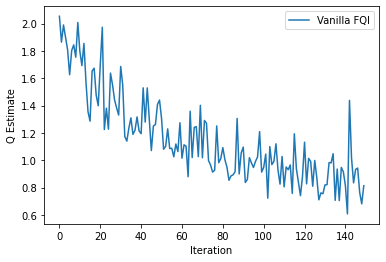

In [20]:
cfqi_agent = CFQIagent(train_tuples=train_tuples, test_tuples=test_tuples)
Q_dist = cfqi_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "Vanilla FQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

In [22]:
cfqi_agent.q_est_shared.coef_

array([  95.47689289,   40.99063213, -204.4189268 , -172.43644231,
       -112.34035699,   -1.7286113 ,   35.31961741, -158.79109713,
       -120.03263256,   29.42662042,   17.93033115,  -75.52397943])

In [23]:
cfqi_agent.q_est_fg.coef_

array([  95.01765759,   47.05547491, -181.39175441, -209.99197713,
        -86.23029248,  -10.47439348,   62.37309704, -144.94003223,
       -150.76744875,   52.22054426,  -12.64509034, -109.53750995])

# Validation (FQI, CFQI, Oracle, Random)

  0%|          | 0/100 [00:00<?, ?it/s]

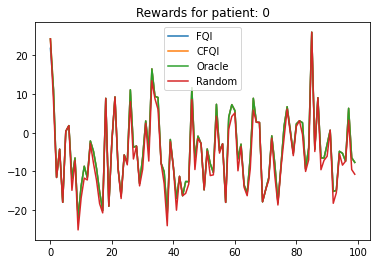

  1%|          | 1/100 [00:00<00:25,  3.94it/s]

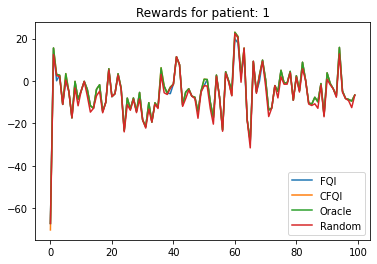

  2%|▏         | 2/100 [00:00<00:26,  3.67it/s]

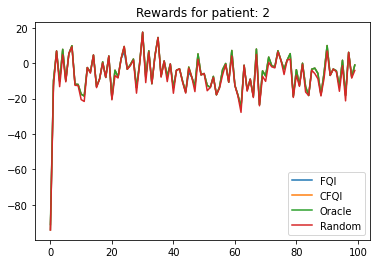

  3%|▎         | 3/100 [00:00<00:25,  3.86it/s]

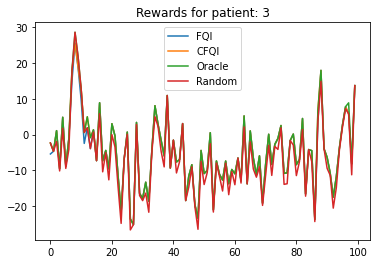

  4%|▍         | 4/100 [00:01<00:23,  4.01it/s]

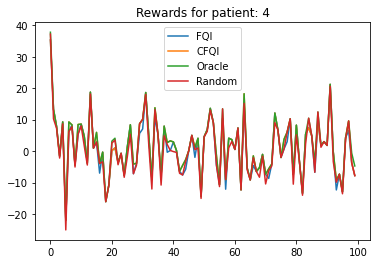

  5%|▌         | 5/100 [00:01<00:24,  3.87it/s]

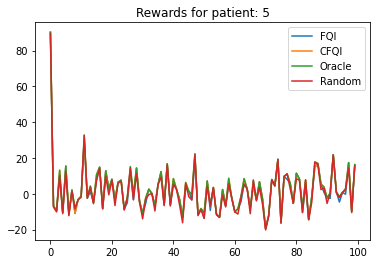

  6%|▌         | 6/100 [00:01<00:23,  4.00it/s]

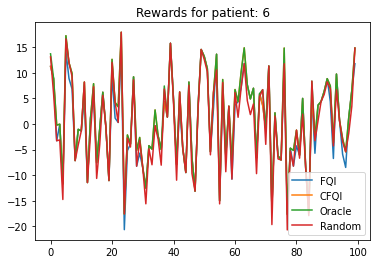

  7%|▋         | 7/100 [00:01<00:23,  4.00it/s]

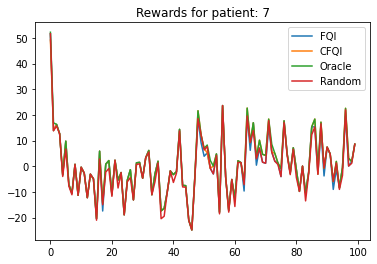

  8%|▊         | 8/100 [00:02<00:22,  4.16it/s]

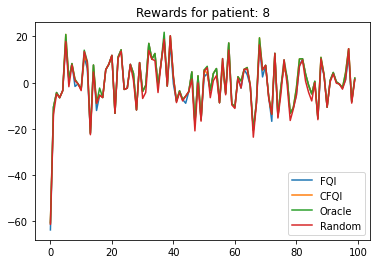

  9%|▉         | 9/100 [00:02<00:21,  4.29it/s]

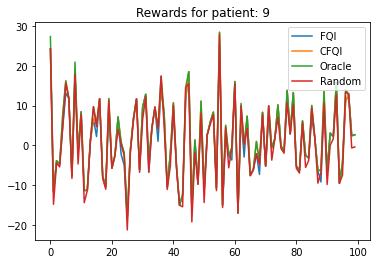

 10%|█         | 10/100 [00:02<00:21,  4.27it/s]

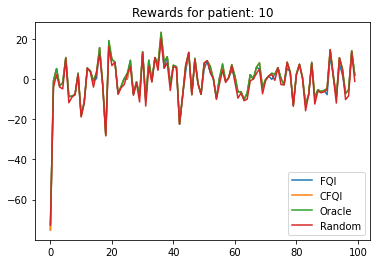

 11%|█         | 11/100 [00:02<00:20,  4.37it/s]

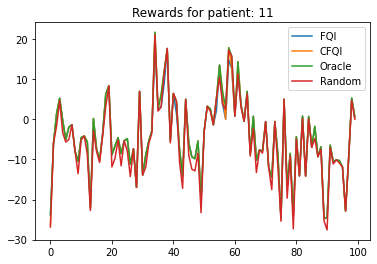

 12%|█▏        | 12/100 [00:02<00:19,  4.47it/s]

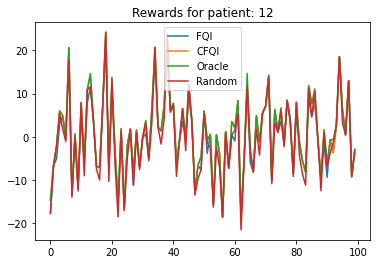

 13%|█▎        | 13/100 [00:03<00:19,  4.43it/s]

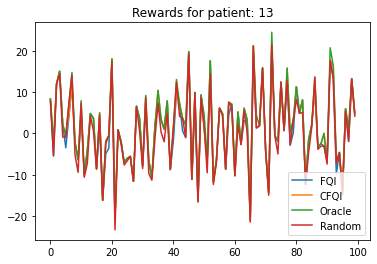

 14%|█▍        | 14/100 [00:03<00:19,  4.44it/s]

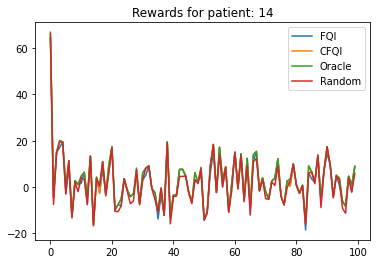

 15%|█▌        | 15/100 [00:03<00:18,  4.50it/s]

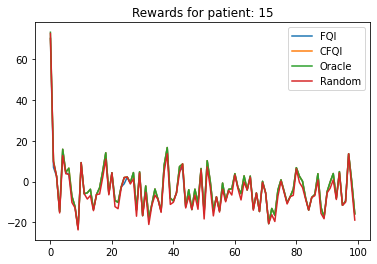

 16%|█▌        | 16/100 [00:03<00:21,  3.94it/s]

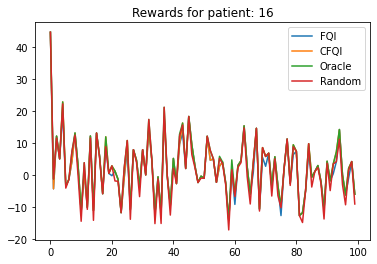

 17%|█▋        | 17/100 [00:04<00:20,  4.07it/s]

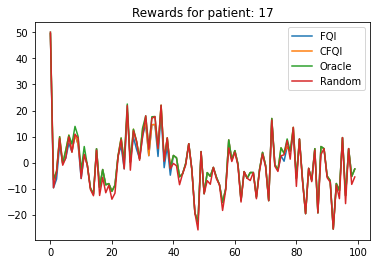

 18%|█▊        | 18/100 [00:04<00:19,  4.17it/s]

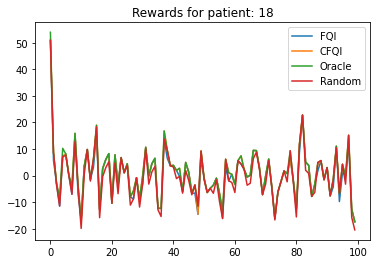

 19%|█▉        | 19/100 [00:04<00:19,  4.25it/s]

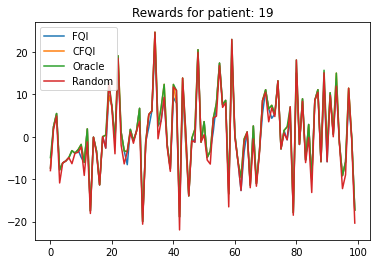

 20%|██        | 20/100 [00:04<00:18,  4.29it/s]

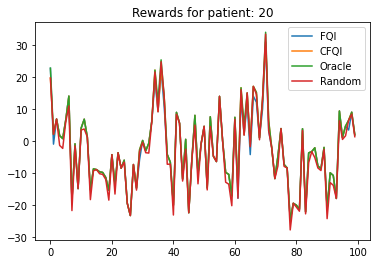

 21%|██        | 21/100 [00:04<00:17,  4.41it/s]

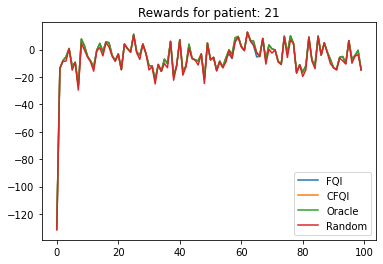

 22%|██▏       | 22/100 [00:05<00:17,  4.40it/s]

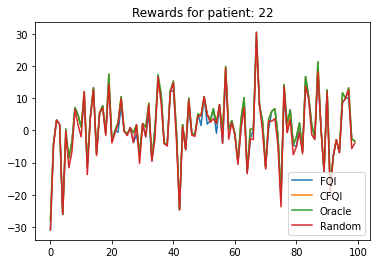

 23%|██▎       | 23/100 [00:05<00:17,  4.32it/s]

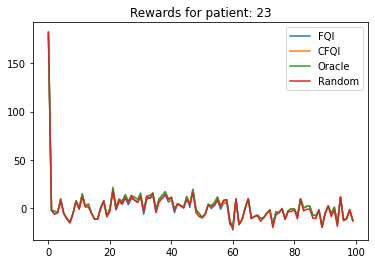

 24%|██▍       | 24/100 [00:05<00:17,  4.45it/s]

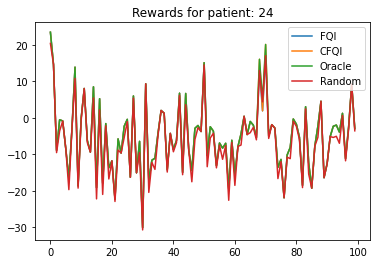

 25%|██▌       | 25/100 [00:05<00:17,  4.39it/s]

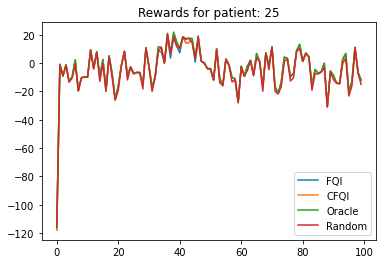

 26%|██▌       | 26/100 [00:06<00:16,  4.41it/s]

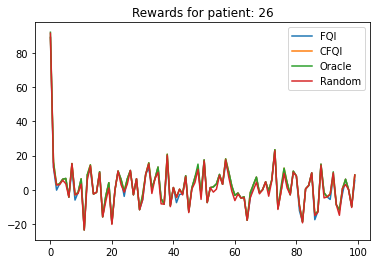

 27%|██▋       | 27/100 [00:06<00:16,  4.42it/s]

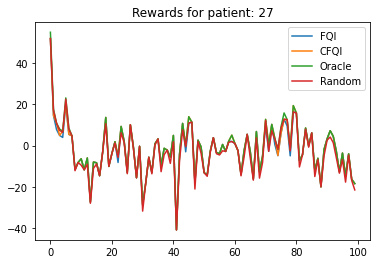

 28%|██▊       | 28/100 [00:06<00:16,  4.49it/s]

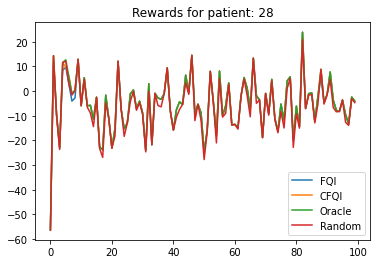

 29%|██▉       | 29/100 [00:06<00:15,  4.45it/s]

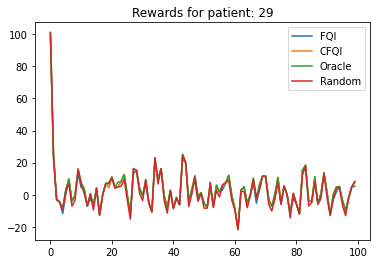

 30%|███       | 30/100 [00:07<00:17,  4.02it/s]

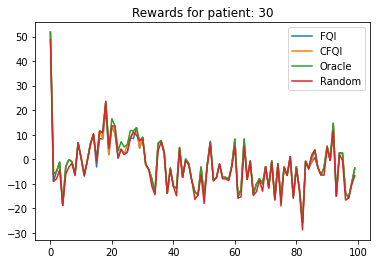

 31%|███       | 31/100 [00:07<00:16,  4.17it/s]

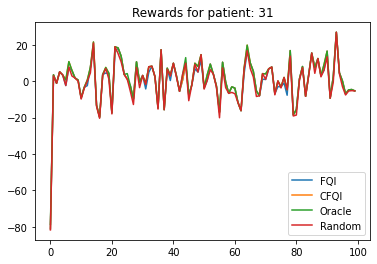

 32%|███▏      | 32/100 [00:07<00:15,  4.36it/s]

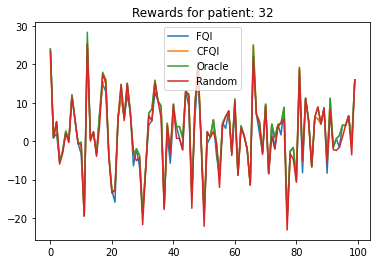

 33%|███▎      | 33/100 [00:07<00:15,  4.42it/s]

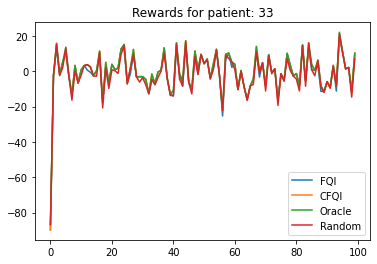

 34%|███▍      | 34/100 [00:07<00:14,  4.50it/s]

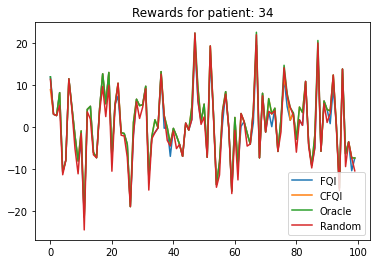

 35%|███▌      | 35/100 [00:08<00:14,  4.58it/s]

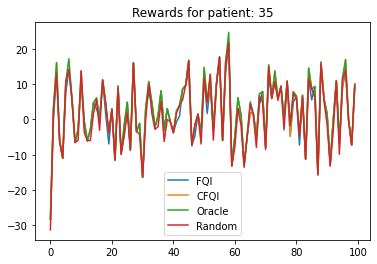

 36%|███▌      | 36/100 [00:08<00:14,  4.50it/s]

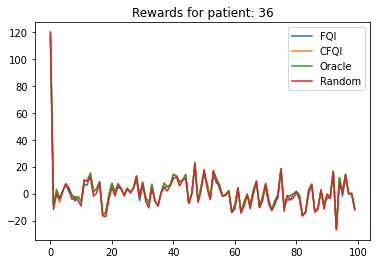

 37%|███▋      | 37/100 [00:08<00:14,  4.47it/s]

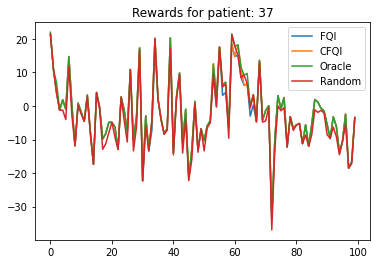

 38%|███▊      | 38/100 [00:08<00:13,  4.46it/s]

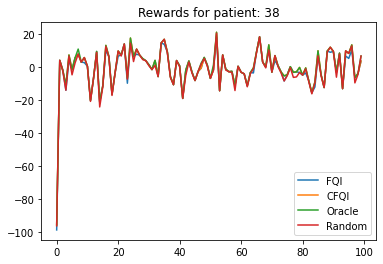

 39%|███▉      | 39/100 [00:09<00:13,  4.43it/s]

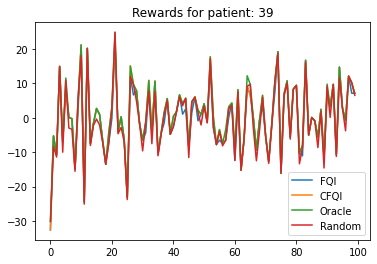

 40%|████      | 40/100 [00:09<00:13,  4.45it/s]

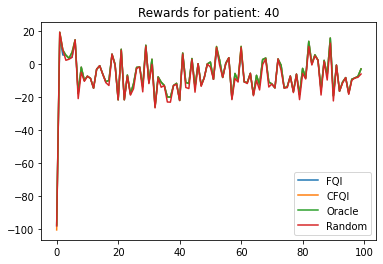

 41%|████      | 41/100 [00:09<00:13,  4.46it/s]

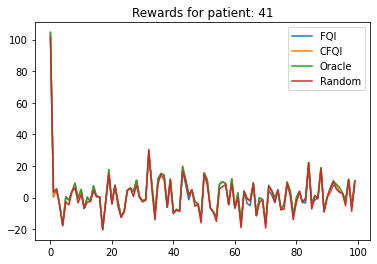

 42%|████▏     | 42/100 [00:09<00:12,  4.53it/s]

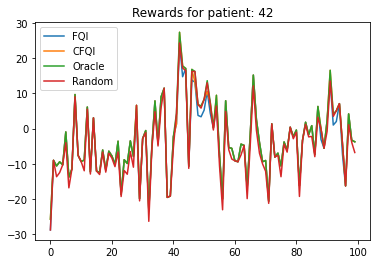

 43%|████▎     | 43/100 [00:09<00:12,  4.56it/s]

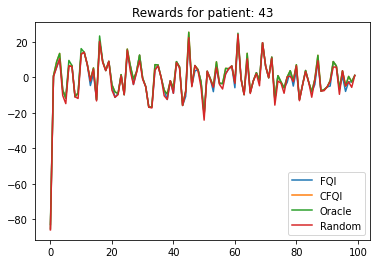

 44%|████▍     | 44/100 [00:10<00:14,  3.94it/s]

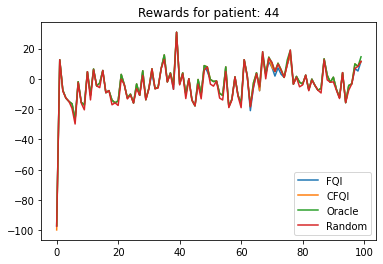

 45%|████▌     | 45/100 [00:10<00:13,  4.07it/s]

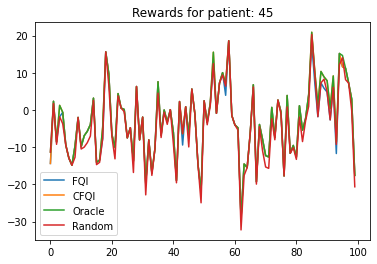

 46%|████▌     | 46/100 [00:10<00:13,  4.12it/s]

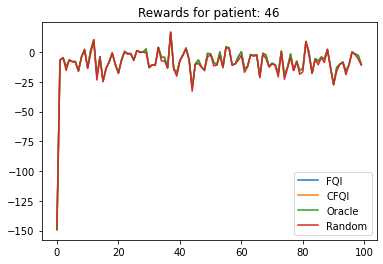

 47%|████▋     | 47/100 [00:10<00:12,  4.30it/s]

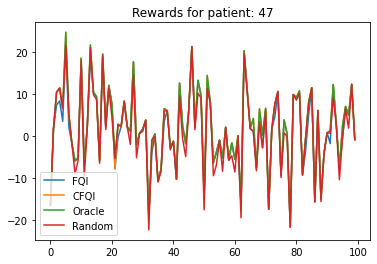

 48%|████▊     | 48/100 [00:11<00:11,  4.35it/s]

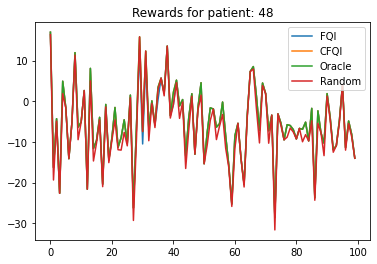

 49%|████▉     | 49/100 [00:11<00:11,  4.37it/s]

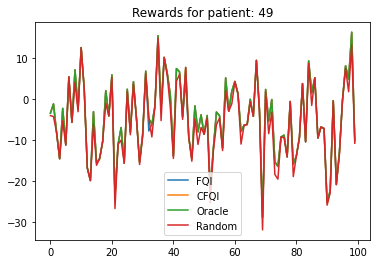

 50%|█████     | 50/100 [00:11<00:11,  4.48it/s]

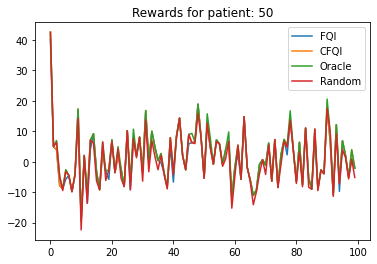

 51%|█████     | 51/100 [00:11<00:11,  4.44it/s]

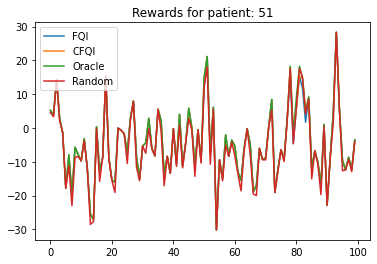

 52%|█████▏    | 52/100 [00:12<00:11,  4.33it/s]

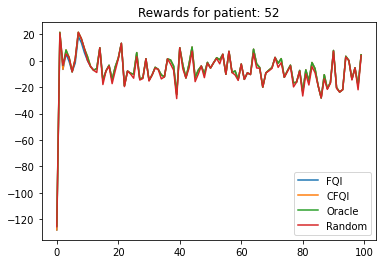

 53%|█████▎    | 53/100 [00:12<00:11,  4.20it/s]

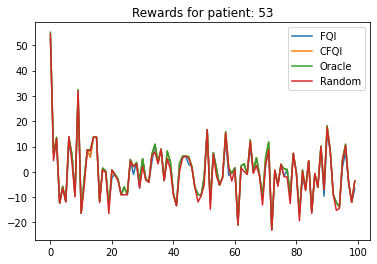

 54%|█████▍    | 54/100 [00:12<00:11,  4.14it/s]

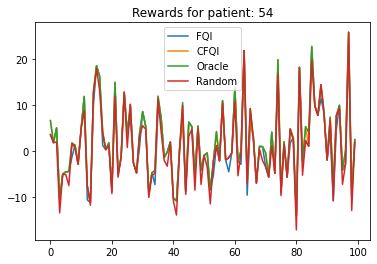

 55%|█████▌    | 55/100 [00:12<00:10,  4.26it/s]

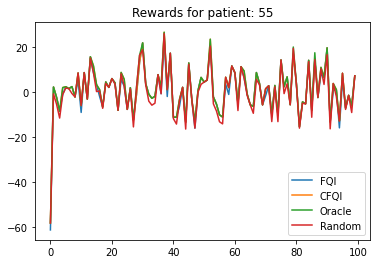

 56%|█████▌    | 56/100 [00:13<00:09,  4.43it/s]

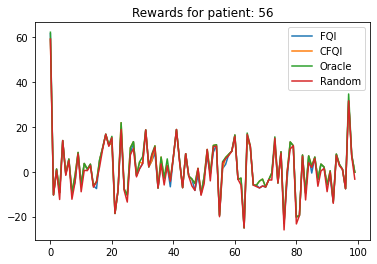

 57%|█████▋    | 57/100 [00:13<00:09,  4.58it/s]

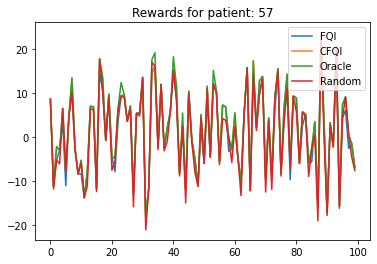

 58%|█████▊    | 58/100 [00:13<00:10,  3.96it/s]

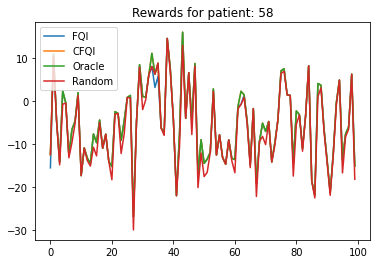

 59%|█████▉    | 59/100 [00:13<00:09,  4.16it/s]

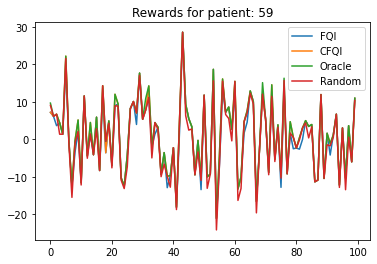

 60%|██████    | 60/100 [00:13<00:09,  4.36it/s]

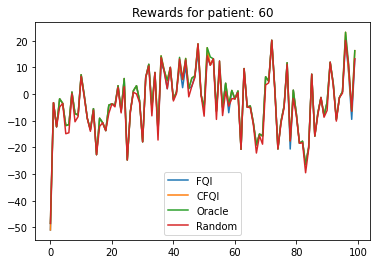

 61%|██████    | 61/100 [00:14<00:08,  4.40it/s]

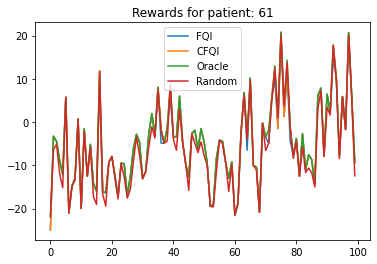

 62%|██████▏   | 62/100 [00:14<00:08,  4.46it/s]

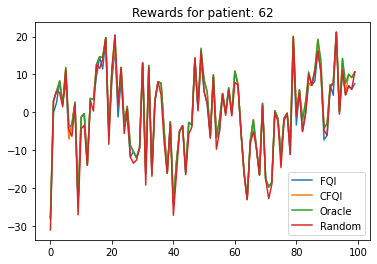

 63%|██████▎   | 63/100 [00:14<00:08,  4.53it/s]

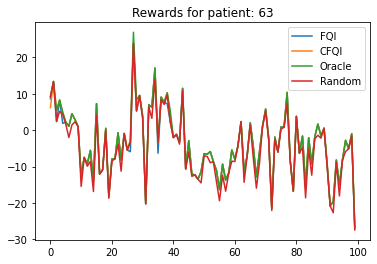

 64%|██████▍   | 64/100 [00:14<00:07,  4.59it/s]

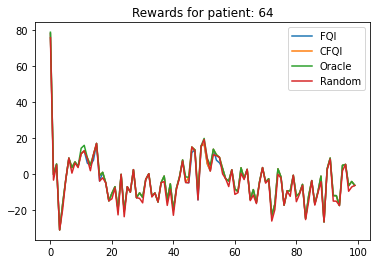

 65%|██████▌   | 65/100 [00:15<00:07,  4.64it/s]

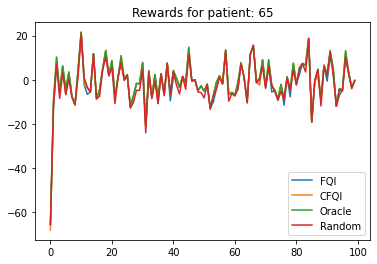

 66%|██████▌   | 66/100 [00:15<00:07,  4.75it/s]

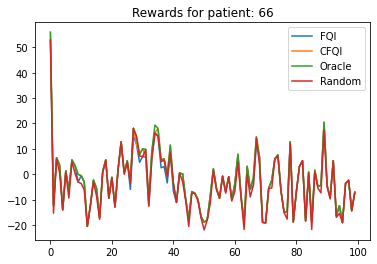

 67%|██████▋   | 67/100 [00:15<00:07,  4.68it/s]

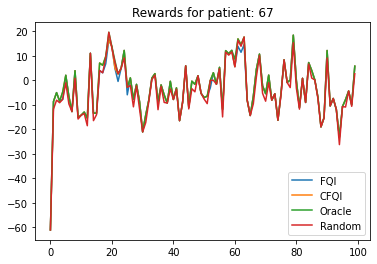

 68%|██████▊   | 68/100 [00:15<00:06,  4.63it/s]

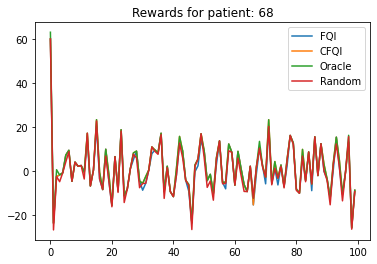

 69%|██████▉   | 69/100 [00:15<00:06,  4.70it/s]

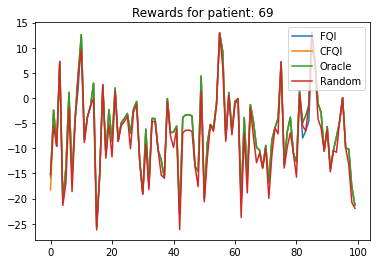

 70%|███████   | 70/100 [00:16<00:06,  4.40it/s]

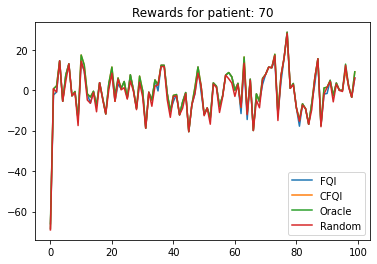

 71%|███████   | 71/100 [00:16<00:06,  4.45it/s]

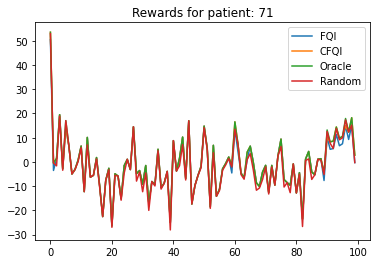

 72%|███████▏  | 72/100 [00:16<00:07,  3.92it/s]

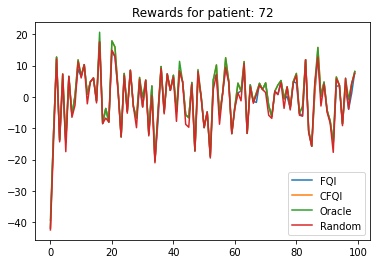

 73%|███████▎  | 73/100 [00:16<00:06,  4.09it/s]

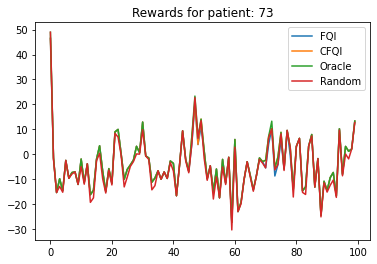

 74%|███████▍  | 74/100 [00:17<00:06,  4.04it/s]

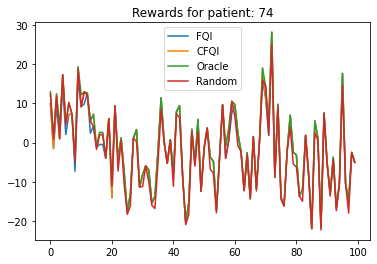

 75%|███████▌  | 75/100 [00:17<00:05,  4.18it/s]

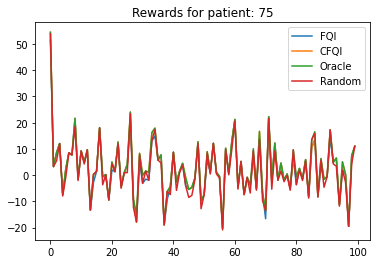

 76%|███████▌  | 76/100 [00:17<00:05,  4.31it/s]

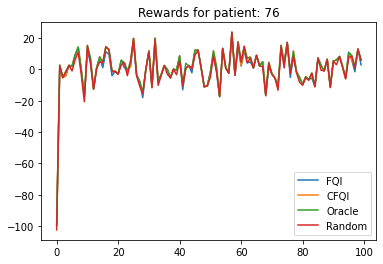

 77%|███████▋  | 77/100 [00:17<00:05,  4.39it/s]

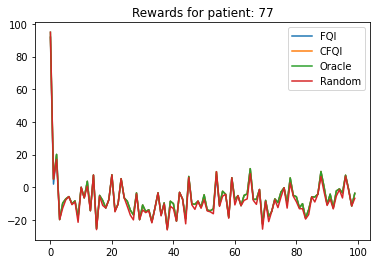

 78%|███████▊  | 78/100 [00:18<00:04,  4.42it/s]

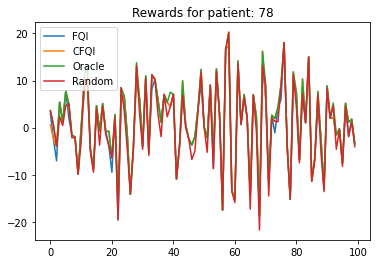

 79%|███████▉  | 79/100 [00:18<00:04,  4.36it/s]

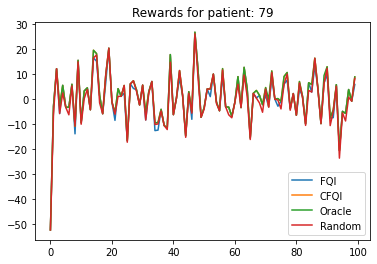

 80%|████████  | 80/100 [00:18<00:04,  4.37it/s]

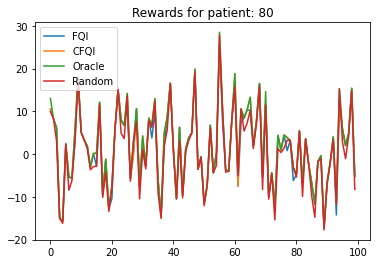

 81%|████████  | 81/100 [00:18<00:04,  4.34it/s]

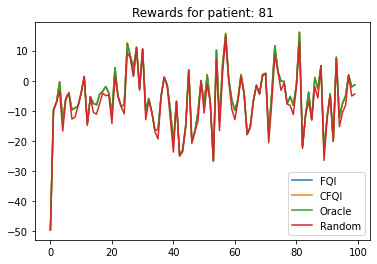

 82%|████████▏ | 82/100 [00:18<00:04,  4.35it/s]

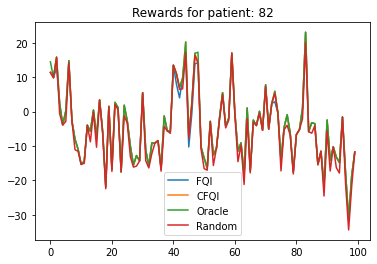

 83%|████████▎ | 83/100 [00:19<00:03,  4.37it/s]

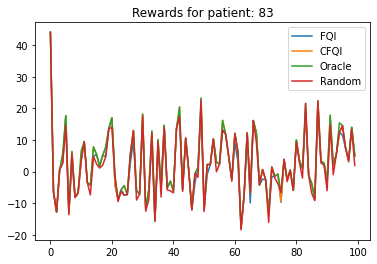

 84%|████████▍ | 84/100 [00:19<00:03,  4.35it/s]

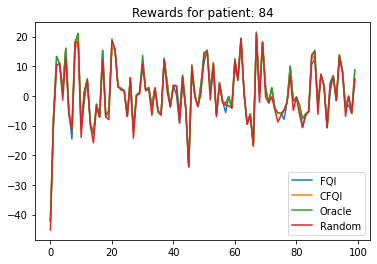

 85%|████████▌ | 85/100 [00:19<00:03,  4.37it/s]

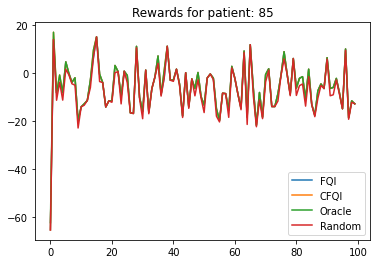

 86%|████████▌ | 86/100 [00:19<00:03,  3.86it/s]

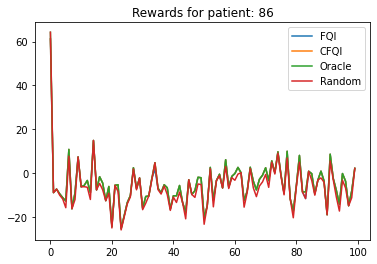

 87%|████████▋ | 87/100 [00:20<00:03,  4.08it/s]

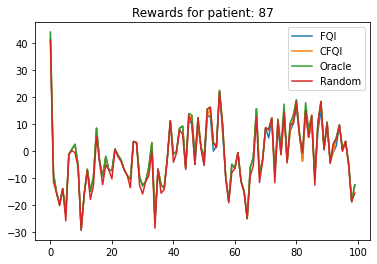

 88%|████████▊ | 88/100 [00:20<00:02,  4.16it/s]

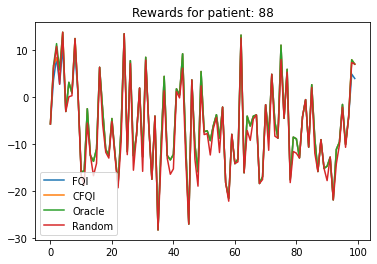

 89%|████████▉ | 89/100 [00:20<00:02,  4.20it/s]

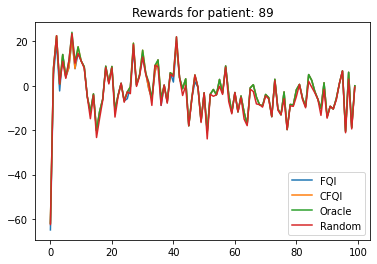

 90%|█████████ | 90/100 [00:20<00:02,  4.28it/s]

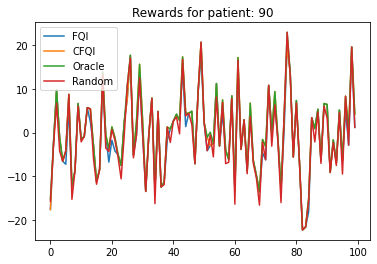

 91%|█████████ | 91/100 [00:21<00:02,  4.29it/s]

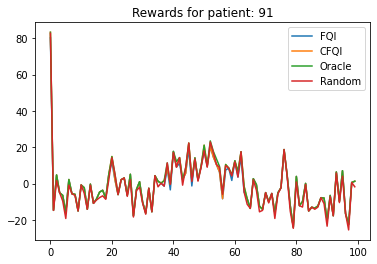

 92%|█████████▏| 92/100 [00:21<00:01,  4.38it/s]

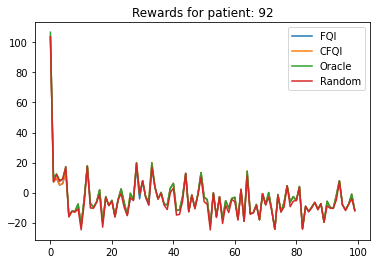

 93%|█████████▎| 93/100 [00:21<00:01,  4.43it/s]

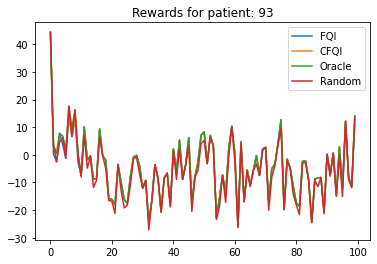

 94%|█████████▍| 94/100 [00:21<00:01,  4.40it/s]

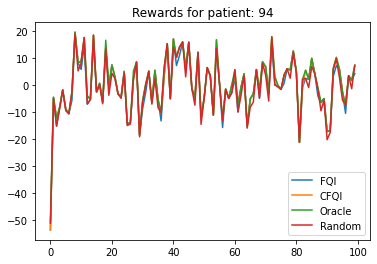

 95%|█████████▌| 95/100 [00:22<00:01,  4.39it/s]

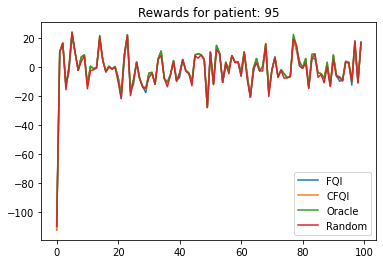

 96%|█████████▌| 96/100 [00:22<00:00,  4.41it/s]

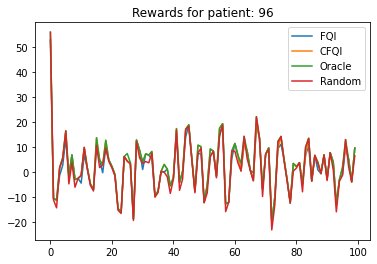

 97%|█████████▋| 97/100 [00:22<00:00,  4.40it/s]

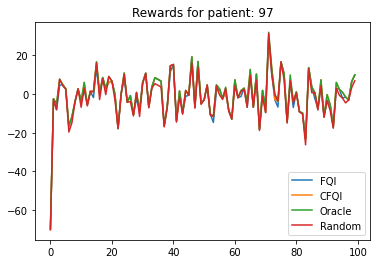

 98%|█████████▊| 98/100 [00:22<00:00,  4.44it/s]

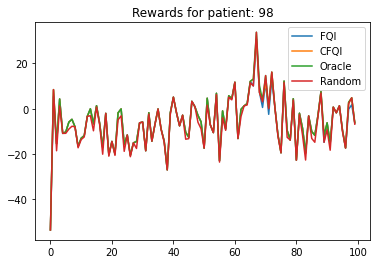

 99%|█████████▉| 99/100 [00:22<00:00,  4.56it/s]

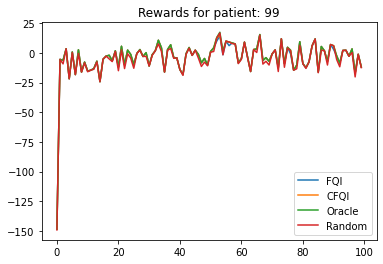

100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


In [32]:
# Test out on each test tuple
# FQI, CFQI, Oracle, Random
algos = ['fqi', 'cfqi', 'oracle', 'random']
for k, pat in enumerate(tqdm.tqdm(range(num_patients))):
    
    flip = np.random.choice(2)
    if flip == 0:
        ds = 'foreground'
    else:
        ds = 'background'
    # Generate a random initial state
    s = np.random.normal(mu, sigma, (10, 1))
    
    val_rewards = {}
    for alg in algos:
        val_rewards[alg] = []
    
    
    # Generate all of the tuples for this patient
    for i in range(num_samples):
        s = s.T
        # FQI agent
        fqi_action = fqi_agent.piE.predict(s)
        if fqi_action[0] > 3:
            fqi_action[0] = 3
        fqi_action = actions[round(fqi_action[0])]
        fqi_action = np.reshape(fqi_action, (2, 1))
        s_a = np.concatenate((s.T, fqi_action))
        val_rewards['fqi'].append(np.dot(reward_function.T, s_a)[0])



        # CFQI agent
        cfqi_action = cfqi_agent.piE.predict(s)
        if cfqi_action[0] > 3:
            cfqi_action[0] = 3
        cfqi_action = actions[round(cfqi_action[0])]
        cfqi_action = np.reshape(cfqi_action, (2, 1))
        s_a = np.concatenate((s.T, cfqi_action))
        val_rewards['cfqi'].append(np.dot(reward_function.T, s_a)[0])


        # Oracle
        all_rewards = []
        for j, a in enumerate(actions):
            a = np.asarray(a)
            a = np.reshape(a, (2, 1))
            s_a = np.concatenate((s.T, a))
            reward = np.dot(reward_function.T, s_a)
            all_rewards.append(reward)

        all_rewards = np.asarray(all_rewards)
        oracle_action = actions[np.argmax(all_rewards)]
        val_rewards['oracle'].append(np.max(all_rewards))


        # Random action
        random_action = np.asarray(actions[np.random.choice(3)])
        random_action = np.reshape(random_action, (2, 1))
        s_a = np.concatenate((s.T, random_action))
        val_rewards['random'].append(np.dot(reward_function.T, s_a)[0])
        
        if ds == 'foreground':
            t_m = transition_foreground
        else:
            t_m = transition_background
        ns = np.matmul(s_a.T, t_m) / np.linalg.norm(np.matmul(s_a.T, t_m), ord=2)
        ns = np.add(ns, np.random.normal(0, 0.5, (1, 10))) # Add noise
        s = ns.T
    
    plt.title("Rewards for patient: " + str(k))
    x = [i for i in range(num_samples)]
    plt.plot(x, val_rewards['fqi'], label="FQI")
    plt.plot(x, val_rewards['cfqi'], label='CFQI')
    plt.plot(x, val_rewards['oracle'], label='Oracle')
    plt.plot(x, val_rewards['random'], label='Random')
    plt.legend()
    plt.show()